In [1]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
from code.organize import *
from code.roughEDA import *
from code.survey_processor_full import *
from code.model_vis import *
from code.fc_cluster import *

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix,roc_curve
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

from treeinterpreter import treeinterpreter as ti
import matplotlib.cm as cm
import cPickle as pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Clustering Feature Contribution Matrix

* pca
* kmeans on principle components

To further classify employed and unemployed women, more studies are needed on feature contribution matrix. To see how random forest classified samples, we need to find out common contribution paths among samples. Using Kmeans to cluster feature contribution matrix is a reasonable approach. However, the matrix has 40 columns, so before clustering, PCA is necessary for dimension reduction.  

In [2]:
fc_df = pd.read_pickle('data/fc_df2.pkl')

## 1.  PCA

In [3]:
fc_f_pca = fc_df.drop(['employed','correct'],axis =1)       #only pass feature columns to pca

pca = PCA(n_components = 10)
pca.fit(fc_f_pca.values)

PCA(copy=True, n_components=10, whiten=False)

In [4]:
np.cumsum(pca.explained_variance_ratio_),pca.explained_variance_ratio_  # accumulated variance in principle componets.

(array([ 0.27067104,  0.40572749,  0.50527836,  0.56708616,  0.61551024,
         0.65216206,  0.68350593,  0.70979973,  0.73464959,  0.75635671]),
 array([ 0.27067104,  0.13505645,  0.09955087,  0.0618078 ,  0.04842407,
         0.03665183,  0.03134387,  0.0262938 ,  0.02484986,  0.02170712]))

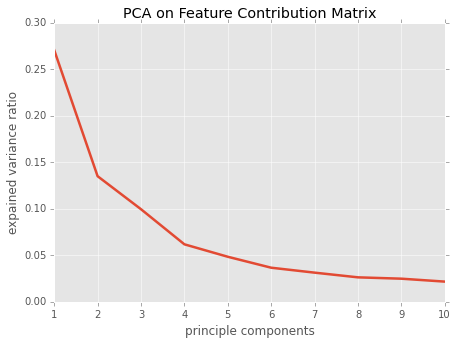

In [5]:
plt.figure(figsize=(7,5))
plt.plot(range(1,11),pca.explained_variance_ratio_, lw = 2.5)
plt.xlabel('principle components')
plt.ylabel('expained variance ratio')
plt.title('PCA on Feature Contribution Matrix')
plt.savefig('imgs/readme_figs/pca')

** Three principle components will be fine **

In [6]:
pca = PCA(n_components=3)
fc_pca = pca.fit_transform(fc_f_pca.values)

### Kmeans

To determine which k for kmeans. I wrote a function to check kmeans cluster performance. 

1. Take a range of Ks and make a for loop

2. In each loop：
  * Generate k clusters using kmeans. concatenate cluster id to 'employed' and 'correct' columns to make a new data frame.
  * Group data frame by cluster id, calcuate employed rate and correct rate by taking means
  * If the employed rate is higher than 0.7 or lower than 0.3, then we can say this cluster successfully group employed or unemployed population, so this cluster yields pure population of interest.
  * If the correct rate is higher than 0.7, we can say this cluter has accuracy.
  * The clusters with pure population and meantime with high accuracy are ones we want. 
  * Therefore, the percentage of good clusters is calculated.
  * Print employed and correct rate of each good cluster, as well as the good cluster ratio.
  
3. plot total number of k against good cluster ratio

4 clusters
         employed   correct
cluster                    
0        0.023209  0.982846
1        0.923353  0.923353
2        0.348921  0.910072
3        0.861071  0.878437
---
4 out of 4 clusters split the target ideally. Good cluster rate: 1.0
********************
5 clusters
         employed   correct
cluster                    
0        0.921053  0.920591
1        0.022222  0.983838
2        0.081744  0.929155
3        0.863173  0.880640
4        0.895753  0.899614
---
5 out of 5 clusters split the target ideally. Good cluster rate: 1.0
********************
6 clusters
         employed   correct
cluster                    
0        0.924484  0.924484
1        0.082192  0.928767
2        0.040498  0.975078
3        0.900459  0.901991
4        0.895753  0.899614
5        0.059809  0.930622
---
6 out of 6 clusters split the target ideally. Good cluster rate: 1.0
********************
7 clusters
         employed   correct
cluster                    
0        0.919614  0.919614
1 

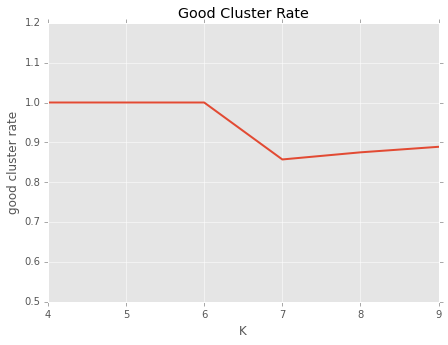

In [7]:
plt.figure(figsize=(7,5))
km_emp_mean(fc_pca,10,fc_df.employed,fc_df.correct)
plt.title('Good Cluster Rate')
plt.savefig('imgs/readme_figs/good_rate')

### Check average silhouette

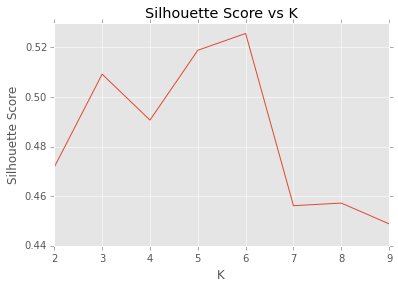

In [12]:
plot_silhouette(fc_pca,10)
plt.title('Silhouette Score vs K')
plt.savefig('imgs/readme_figs/sil_K')

### Check each cluster's silhoutte score when K is 6.

('For n_clusters =', 6, 'The average silhouette_score is :', 0.52546132160706249)


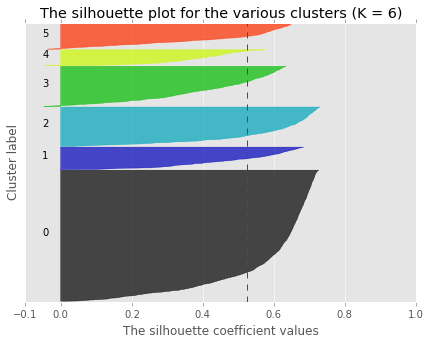

In [14]:
cluster_plot(fc_pca,6)
plt.savefig('imgs/readme_figs/cluster_plot')

According to the results, all the Kmeans cluster showed high good cluster ratios. When the number of cluster for kmeans is six, it has 100% good cluster ratio, 3 employed, 3 unemployed. Moreover, it exhibited very high silhouette score. Thus, n_cluster will be set to 6.

In [10]:
km = KMeans(n_clusters=6,random_state=0)
km.fit(fc_pca)
fc_df['cluster'] = km.labels_

In [11]:
fc_df.groupby('cluster')['employed'].agg([np.mean,np.size])

,mean,size
cluster,,
0,0.924484,2132
1,0.082192,365
2,0.040498,642
3,0.900459,653
4,0.895753,259
5,0.059809,418


**To make this process replicable, a class function, FeatureContribution is written and saved as fc_cluster.py under data diretory. Now let's give it a shot.**

In [12]:
fc = FeatureContribution('data/fc_df2.pkl')

cluster_processor is the main function. The first argument is the **n_components** for pca and the second argument is the **n_cluster** for Kmeans. It returns a data frame which is orginal feature contribution data frame with an additional cluster id column generated from Kmeans.

In [13]:
fc_df = fc.cluster_processor(3,6)

In [14]:
fc_df.shape

(4469, 43)

In [15]:
fc_df.head()

,coninc,age,educom,degree,sphrs1,partyid,agekdbrn,class_,dwelling,polviews,...,natfare,marital,divlaw,affrmact,helpnot,life,spanking,employed,correct,cluster
0,-0.024180,0.012212,0.004822,0.025785,0.003010,0.005950,0.023872,-0.082842,-0.039021,-0.005935,...,0.023788,0.004271,0.003521,0.000336,-0.004642,0.000422,0.000950,True,True,3
1,0.002730,-0.004376,0.008302,0.014275,-0.018376,-0.000277,0.007874,-0.041408,0.012293,0.000421,...,0.007787,-0.008250,0.001585,-0.000391,0.003435,0.006826,0.008383,False,False,0
2,-0.008768,0.027119,-0.038023,0.013832,-0.044665,-0.012495,-0.019889,-0.049807,-0.004495,-0.002228,...,-0.010834,-0.012121,-0.003478,-0.004329,-0.025902,-0.008582,-0.011836,False,True,2
3,0.007878,-0.046130,-0.012555,-0.001003,0.012358,-0.033311,-0.032281,-0.047386,-0.012148,-0.015564,...,0.006761,0.002884,-0.021230,-0.013306,-0.001434,-0.002780,-0.005327,False,True,2
4,-0.113355,-0.023602,-0.129956,0.013399,-0.004473,-0.002051,-0.034877,-0.017012,-0.046539,-0.016746,...,-0.004402,0.010967,0.009405,-0.028089,0.003807,-0.001978,-0.006098,False,True,5


In [16]:
fc_df.groupby('cluster')['employed'].agg([np.mean,np.size])

,mean,size
cluster,,
0,0.924484,2132
1,0.082192,365
2,0.040498,642
3,0.900459,653
4,0.895753,259
5,0.059809,418
